In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
bs = 8

In [2]:
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.metrics import *
from fastai.callbacks import *

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/rawdata")
df = pd.read_csv(path/'MSI_IMDB.csv')
df

,Unnamed: 0,Title,plot,genre
0,0,Megamind,"When a planet is about to be destroyed, two al...","Animation,Action,Comedy,Family,Sci-Fi"
1,1,Slumdog Millionaire,"The story of Jamal Malik, an 18 year-old orpha...","Drama,Romance"
2,2,Om Shanti Om,Om Prakash is a junior artist and has dreams t...,"Action,Comedy,Drama,Musical,Romance,Thriller"
3,3,The Silence of the Lambs,F.B.I. trainee Clarice Starling (Jodie Foster)...,"Crime,Drama,Thriller"
4,4,Terminator 2: Judgment Day,Over 10 years have passed since the first mach...,"Action,Sci-Fi"
...,...,...,...,...
434,434,Naruto: Shippûden,"Naruto Uzumaki, is a loud, hyperactive, adoles...","Animation,Action,Adventure,Comedy,Drama,Fantasy"
435,435,No Dorai,"In a small beach town in Bangladesh, fearless ...",Drama
436,436,Bhoothnath,"Aditya is an Engineer on a cruise line, and li...","Comedy,Drama,Family,Fantasy"
437,437,The Wolf of Wall Street,"In 1987, Jordan Belfort procures a job as a Wa...","Biography,Crime,Drama"


**Merging Poster and Plot Data**

In [5]:
path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/processed_data")
data_lm = load_data(path, 'data_lm1.pkl', bs=bs)
vocab = data_lm.vocab 
size=256

In [6]:
path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/rawdata")
PosterList = ImageList.from_folder(path/'tr_img')
PlotList = TextList.from_csv(path, 'MSI_IMDB.csv', cols='plot', vocab = vocab)

mixed = (MixedItemList([PosterList, PlotList], path, inner_df=PlotList.inner_df)
            .split_by_rand_pct(0.2)
            .label_from_df(cols='genre',label_delim=',')
            .transform([[get_transforms()[0], [], []], [get_transforms()[1], [], []]], size=size))

mixed

LabelLists;

Train: LabelList (352 items)
x: MixedItemList
MixedItem
Image (3, 256, 256)
Text [   2    6    0 2419 ...   51   10    0   11],MixedItem
Image (3, 256, 256)
Text [   2    5  136    0 ...    0   36 1568   11],MixedItem
Image (3, 256, 256)
Text [  2   5  72 745 ... 136  10  57  11],MixedItem
Image (3, 256, 256)
Text [   2    5  750 1141 ...   37 1575  428   11],MixedItem
Image (3, 256, 256)
Text [   2    6 1576 1142 ...   12   10 1930   11]
y: MultiCategoryList
Crime;Drama;Thriller,Action;Sci-Fi,Action;Adventure;Sci-Fi;Thriller,Crime;Drama;Thriller,Crime;Drama;Mystery;Sci-Fi;Thriller
Path: /content/drive/My Drive/Colab Notebooks/Genre Classification/rawdata;

Valid: LabelList (87 items)
x: MixedItemList
MixedItem
Image (3, 256, 256)
Text [  2   5 839  12 ...   0  17   0  80],MixedItem
Image (3, 256, 256)
Text [   2   14 1430    9 ... 1240    0 2255   11],MixedItem
Image (3, 256, 256)
Text [  2   5 903   5 ... 544  15  79  11],MixedItem
Image (3, 256, 256)
Text [   2    5   1

In [7]:
mixed.c,mixed.classes

(21,
 ['Action',
  'Adventure',
  'Animation',
  'Biography',
  'Comedy',
  'Crime',
  'Drama',
  'Family',
  'Fantasy',
  'History',
  'Horror',
  'Music',
  'Musical',
  'Mystery',
  'Romance',
  'Sci-Fi',
  'Short',
  'Sport',
  'Thriller',
  'War',
  'Western'])

In [8]:
path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/processed_data")
outfile = open(path/'mixed1.pkl', 'wb')
pickle.dump(mixed, outfile)
outfile.close()

In [9]:
path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/processed_data")
infile = open(path/'mixed1.pkl','rb')
mixed = pickle.load(infile)
infile.close()

**DataBunch for text portion**

In [10]:
path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/rawdata")
data_text = (TextList.from_csv(path, 'MSI_IMDB.csv', cols='plot', vocab = vocab)
                .split_none()
                .label_from_df(cols='genre',label_delim=',')
                .databunch(bs=bs))

In [11]:
path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/processed_data")
data_text.save(path/'data_text1.pkl')

In [12]:
path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/processed_data")
data_text = load_data(path, 'data_text1.pkl', bs=bs)

**Each row in our batch will contain an array of stuff, first the image data, then the the text data.**

In [13]:
def _normalize_images_batch(b:Tuple[Tensor,Tensor], mean:FloatTensor, std:FloatTensor)->Tuple[Tensor,Tensor]:
    "`b` = `x`,`y` - normalize `x` array of imgs and `do_y` optionally `y`."
    x,y = b
    mean,std = mean.to(x[0].device),std.to(x[0].device)
    x[0] = normalize(x[0],mean,std)
    return x,y

def normalize_custom_funcs(mean:FloatTensor, std:FloatTensor, do_x:bool=True, do_y:bool=False)->Tuple[Callable,Callable]:
    "Create normalize/denormalize func using `mean` and `std`, can specify `do_y` and `device`."
    mean,std = tensor(mean),tensor(std)
    return (partial(_normalize_images_batch, mean=mean, std=std),
            partial(denormalize, mean=mean, std=std))

**collate_mixed is the method responsible to take a batch with variable size rows (because of the variable Description text size) and make them all of equal length so that we can have uniform batch sizes. We basically find the row in the batch which have to longest text, take its length and make all other rows the same length by padding them with zeroes at the end.**

In [14]:
def collate_mixed(samples, pad_idx:int=0):
    # Find max length of the text from the MixedItemList
    max_len = max([len(s[0].data[1]) for s in samples])

    for s in samples:
        res = np.zeros(max_len + pad_idx, dtype=np.int64)
        res[:len(s[0].data[1])] = s[0].data[1]
        s[0].data[1] = res

    return data_collate(samples)

**Transforming Mixed List into DataBunch**

In [15]:
data = mixed.databunch(bs=bs, collate_fn=collate_mixed)

norm, denorm = normalize_custom_funcs(*imagenet_stats)
data.add_tfm(norm) # normalize images

In [16]:
data.c

21

**Model Architecture**

In [17]:
#Metrics
arch = models.resnet50
acc_02 = partial(accuracy_thresh, thresh=0.3)
f_score = partial(fbeta, thresh=0.3)

In [ ]:
# Pretrained NLP Model
# learn_plot = text_classifier_learner(data_text, AWD_LSTM, drop_mult=0.3, metrics=[acc_02, f_score])
# path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/processed_data")
# learn_plot.load(path/'final_pass1');

In [ ]:
# learn_plot.model[-1].layers = learn_plot.model[-1].layers[:-3] 
# learn_plot.model

In [18]:
# Pretrained Image Model
# path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/rawdata")
# tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.0, max_warp=0.)
# np.random.seed(42)
# src = (ImageList.from_csv(path, 'MSI_IMDB.csv', folder='tr_img', suffix='.png')
#                 .split_by_rand_pct(0.2)
#                 .label_from_df(cols='genre',label_delim=',')
#                 )
# data_img = (src.transform(tfms, size=size)
#            .databunch().normalize(imagenet_stats))

In [19]:
# learn_poster = cnn_learner(data_img, arch, metrics=[acc_02, f_score])
# path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/image_model")
# learn_poster.load(path/'stage-2-256-rn50')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
# learn_poster.model = learn_poster.model[0]
# learn_poster

In [ ]:
# Pretrained Encoder
# path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/processed_data")
# learn.load_encoder(path/'fine_tuned1_enc')

In [ ]:
# Custom 
class ImageTextModel(nn.Module):
    def __init__(self, vocab_sz:int, encoder, use_trainer):
        super().__init__()
        self.use_trainer = use_trainer
        self.cnn = create_body(arch)
        nf = num_features_model(self.cnn) * 2
        drop = .3

        self.lm_encoder = SequentialRNN(encoder[0], PoolingLinearClassifier([400 * 3] + [32], [.3]))

        self.reduce = nn.Sequential(*([AdaptiveConcatPool2d(), Flatten()] + bn_drop_lin(nf, 512, bn=True, p=drop, actn=nn.ReLU(inplace=True))))
        self.merge = nn.Sequential(*bn_drop_lin(512 + 32, 128, bn=True, p=drop, actn=nn.ReLU(inplace=True)))
        self.final = nn.Sequential(*bn_drop_lin(128, 64, bn=True, p=drop, actn=nn.ReLU(inplace=True)))
        self.extra = nn.Sequential(*bn_drop_lin(64, data.c, bn=False, p=0, actn=None))

    def forward(self, img:Tensor, text:Tensor) -> Tensor:
        imgCnn = self.cnn(img)
        imgLatent = self.reduce(imgCnn)
        textLatent = self.lm_encoder(text)

        cat = torch.cat([imgLatent, F.relu(textLatent[0])], dim=1)

        pred = self.extra(self.final(self.merge(cat)))
        # pred = torch.sigmoid(pred)  # making sure this is in the range data.c

        if(not self.use_trainer):
            return pred
        else:
            return pred, textLatent

    def reset(self):
        for c in self.children():
            if hasattr(c, 'reset'): c.reset()

**Learners**

In [ ]:
def split_layers(model:nn.Module) -> List[nn.Module]:
    groups = [[model.cnn, model.lm_encoder]]
    groups += [[model.reduce, model.merge, model.final, model.extra]]
    return groups

In [ ]:
class RNNTrainerCustom(RNNTrainer):
    def on_loss_begin(self, last_output:Tuple[Tensor,Tensor,Tensor], **kwargs):
        "Save the extra outputs for later and only returns the true output."
        self.raw_out,self.out = last_output[1][1],last_output[1][2]
        return {'last_output': last_output[0]}

class ImageTextLearner(Learner):
    def __init__(self, data:DataBunch, model:nn.Module, use_trainer:bool=False, alpha:float=2., beta:float=1., **learn_kwargs):
        super().__init__(data, model, **learn_kwargs)
        if(use_trainer):
            self.callbacks.append(RNNTrainerCustom(self, alpha=alpha, beta=beta))
        self.split(split_layers)

In [ ]:
def image_text_learner(data, vocab_sz, data_lm, use_trainer:bool=False):
    l = text_classifier_learner(data_lm, AWD_LSTM, drop_mult=0.3)
    path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/processed_data")
    l.load_encoder(path/'fine_tuned1_enc')

    model = ImageTextModel( vocab_sz, l.model, use_trainer)

    learn = ImageTextLearner(data, model, use_trainer, metrics=[acc_02, f_score])
    return learn

In [ ]:
learn = image_text_learner(data, len(vocab.itos), data_text, use_trainer=True)

In [ ]:
learn

ImageTextLearner(data=DataBunch;

Train: LabelList (352 items)
x: MixedItemList
MixedItem
Image (3, 256, 256)
Text [   2    5   42   14 ...  963    5 2404   11],MixedItem
Image (3, 256, 256)
Text [ 2  5 10 86 ... 53 13 74 11],MixedItem
Image (3, 256, 256)
Text [   2    5  737    5 ... 2415   22 1906   11],MixedItem
Image (3, 256, 256)
Text [   2    5  136    0 ...    0   36 1568   11],MixedItem
Image (3, 256, 256)
Text [  2   5  72 745 ... 136  10  57  11]
y: MultiCategoryList
Animation;Action;Comedy;Family;Sci-Fi,Drama;Romance,Action;Comedy;Drama;Musical;Romance;Thriller,Action;Sci-Fi,Action;Adventure;Sci-Fi;Thriller
Path: /content/drive/My Drive/Colab Notebooks/Genre Classification/rawdata;

Valid: LabelList (87 items)
x: MixedItemList
MixedItem
Image (3, 256, 256)
Text [  2   5  10 145 ...  12  17 114  11],MixedItem
Image (3, 256, 256)
Text [  2   5 489   5 ...  17 492 159  80],MixedItem
Image (3, 256, 256)
Text [  2   5 338 102 ...  12  44 261  11],MixedItem
Image (3, 256, 256)
Tex

**Training**

In [ ]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


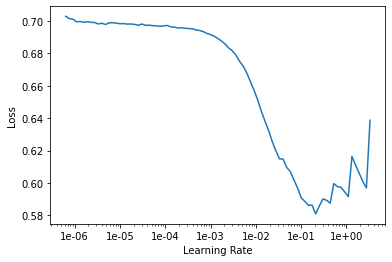

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-1

In [ ]:
learn.fit_one_cycle(1, max_lr=lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.470976,0.369220,0.789819,0.502403,00:32


In [ ]:
path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/mixed_model")
learn.save(path/'mixed_fit_head1')

In [ ]:
path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/mixed_model")
learn.load(path/'mixed_fit_head1');

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


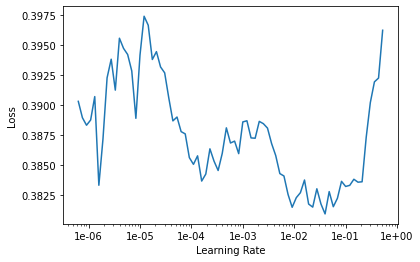

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = slice(5e-5, 2e-4)

slice(5e-05, 0.0002, None)

In [ ]:
learn.fit_one_cycle(1, max_lr=lr,moms=(0.8,0.7)) #26

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.323325,0.337819,0.814450,0.578252,00:57


In [ ]:
path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/mixed_model")
learn.save(path/'mixed_first_pass1')

In [ ]:
path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/mixed_model")
learn.load(path/'mixed_first_pass1')

ImageTextLearner(data=DataBunch;

Train: LabelList (352 items)
x: MixedItemList
MixedItem
Image (3, 256, 256)
Text [   2    5   42   14 ...  963    5 2404   11],MixedItem
Image (3, 256, 256)
Text [ 2  5 10 86 ... 53 13 74 11],MixedItem
Image (3, 256, 256)
Text [   2    5  737    5 ... 2415   22 1906   11],MixedItem
Image (3, 256, 256)
Text [   2    6    0 2419 ...   51   10    0   11],MixedItem
Image (3, 256, 256)
Text [   2    5  136    0 ...    0   36 1568   11]
y: MultiCategoryList
Animation;Action;Comedy;Family;Sci-Fi,Drama;Romance,Action;Comedy;Drama;Musical;Romance;Thriller,Crime;Drama;Thriller,Action;Sci-Fi
Path: /content/drive/My Drive/Colab Notebooks/Genre Classification/rawdata;

Valid: LabelList (87 items)
x: MixedItemList
MixedItem
Image (3, 256, 256)
Text [  2   5 311 207 ...  16 532  75  11],MixedItem
Image (3, 256, 256)
Text [  2   5  39 387 ...  18 223 472  80],MixedItem
Image (3, 256, 256)
Text [ 2  5 16 14 ...  5  0 32 11],MixedItem
Image (3, 256, 256)
Text [   2    5

**TEST**

In [ ]:
learn.export()

In [ ]:
defaults.device = torch.device('cpu')

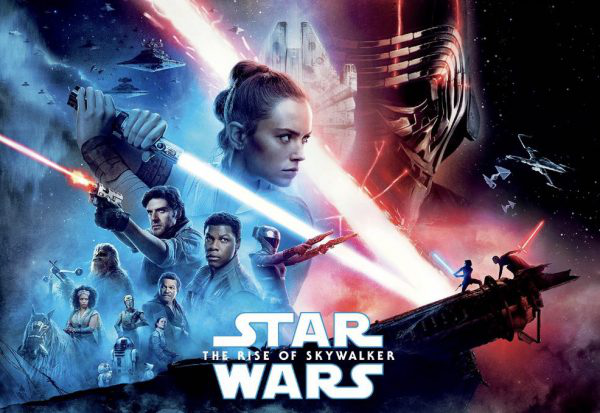

In [ ]:
path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/test_data/poster")
img = open_image(path/'SW.jpg')
img

In [ ]:
path = Path("/content/drive/My Drive/Colab Notebooks/Genre Classification/test_data/plot")
tx = open_text(path/"SW.txt")
tx

'While the First Order continues to ravage the galaxy, Rey finalizes her training as a Jedi. But danger suddenly rises from the ashes as the evil Emperor Palpatine mysteriously returns from the dead. While working with Finn and Poe Dameron to fulfill a new mission, Rey will not only face Kylo Ren once more, but she will also finally discover the truth about her parents as well as a deadly secret that could determine her future and the fate of the ultimate final showdown that is to come.'

In [ ]:
tokenizer = Tokenizer()
tok = SpacyTokenizer('en')
trans = ' '.join(tokenizer.process_text(tx, tok))
trans

'xxmaj while the xxmaj first xxmaj order continues to ravage the galaxy , xxmaj rey finalizes her training as a xxmaj jedi . xxmaj but danger suddenly rises from the ashes as the evil xxmaj emperor xxmaj palpatine mysteriously returns from the dead . xxmaj while working with xxmaj finn and xxmaj poe xxmaj dameron to fulfill a new mission , xxmaj rey will not only face xxmaj kylo xxmaj ren once more , but she will also finally discover the truth about her parents as well as a deadly secret that could determine her future and the fate of the ultimate final showdown that is to come .'

In [ ]:
it = [img,trans]
pred_class,pred_idx,outputs = learn.predict(it)
pred_class.obj